# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# base
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV,
)

# preprocessing and pipeline (workflow)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    mean_squared_error,
    precision_score, 
    recall_score,
    f1_score,
    make_scorer, 
    accuracy_score
)

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# Import cleaned data

In [2]:
df = pd.read_csv("../data/summer_women_100m_swimming_freestyle.csv")

In [3]:
df.head()

,Unnamed: 0,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Medal,Times_Participated,Participation_Number
0,1301,Ilona cs (-Zimmermann),16.0,171.324363,61.754786,HUN,1936,Berlin,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1
1,1738,"Margarete ""Grete"" Adler",16.0,171.324363,61.754786,AUT,1912,Stockholm,Swimming,Swimming Women's 100 metres Freestyle,no medal,2,1
2,2408,Elisabeth Ulla Johanna kesdotter Ahlgren (-Bor...,23.0,171.324363,61.754786,SWE,1948,London,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1
3,3097,Anastasiya Sergeyevna Aksenova,18.0,182.000000,65.000000,RUS,2008,Beijing,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1
4,4272,"Joan ""Jody"" Alderson (-Braskamp)",17.0,170.000000,59.000000,USA,1952,Helsinki,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1


In [4]:
df = df.drop(columns=["Unnamed: 0"])

In [5]:
print(df.shape)
df.head()

(895, 12)


,Name,Age,Height,Weight,NOC,Year,City,Sport,Event,Medal,Times_Participated,Participation_Number
0,Ilona cs (-Zimmermann),16.0,171.324363,61.754786,HUN,1936,Berlin,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1
1,"Margarete ""Grete"" Adler",16.0,171.324363,61.754786,AUT,1912,Stockholm,Swimming,Swimming Women's 100 metres Freestyle,no medal,2,1
2,Elisabeth Ulla Johanna kesdotter Ahlgren (-Bor...,23.0,171.324363,61.754786,SWE,1948,London,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1
3,Anastasiya Sergeyevna Aksenova,18.0,182.000000,65.000000,RUS,2008,Beijing,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1
4,"Joan ""Jody"" Alderson (-Braskamp)",17.0,170.000000,59.000000,USA,1952,Helsinki,Swimming,Swimming Women's 100 metres Freestyle,no medal,1,1


In [6]:
df.isna().sum()

Name                    0
Age                     0
Height                  0
Weight                  0
NOC                     0
Year                    0
City                    0
Sport                   0
Event                   0
Medal                   0
Times_Participated      0
Participation_Number    0
dtype: int64

## Preprocessing

### Split data into train and test

In [7]:
X = df.drop(columns=["Medal"])      
y = df["Medal"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55, stratify=y)      
X_train.shape, X_test.shape

((716, 11), (179, 11))

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 716 entries, 9 to 93
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  716 non-null    object 
 1   Age                   716 non-null    float64
 2   Height                716 non-null    float64
 3   Weight                716 non-null    float64
 4   NOC                   716 non-null    object 
 5   Year                  716 non-null    int64  
 6   City                  716 non-null    object 
 7   Sport                 716 non-null    object 
 8   Event                 716 non-null    object 
 9   Times_Participated    716 non-null    int64  
 10  Participation_Number  716 non-null    int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 67.1+ KB


### Separate categorical and numerical features

In [10]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_features, numeric_features

(['Name', 'NOC', 'City', 'Sport', 'Event'],
 ['Age',
  'Height',
  'Weight',
  'Year',
  'Times_Participated',
  'Participation_Number'])

### Define transformers pipelines

#### Standard transformer

In [11]:
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
categorical_transformer

,steps,"[('onehot', ...)]"
,transform_input,None
,memory,None
,verbose,False
,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None


In [12]:
numeric_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
numeric_transformer

,steps,"[('scaler', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True


In [13]:
preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                               ("cat", categorical_transformer, categorical_features)
                                               ]).set_output(transform="pandas")
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


#### Transformer for decision trees 
(since they don't require scaling)

In [14]:
categorical_transformer_tree = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])

preprocessor_tree = ColumnTransformer(transformers=[("num", "passthrough", numeric_features),       # passthrough -> does nothing, no scaling
                                                    ("cat", categorical_transformer_tree, categorical_features)
                                                    ]).set_output(transform="pandas")
preprocessor_tree

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,categories,'auto'
,drop,None
,sparse_output,False


# Models

### Create a dataframe to keep scores

In [15]:
scores_df = pd.DataFrame(columns=[
    "model_name",
    "F1",
    "Precision",
    "Recall",
])

scores_df

,model_name,F1,Precision,Recall


In [16]:
def add_row(df, y_test=None, y_pred=None, model_name=None):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    new_row = {
        "model_name": model_name,
        "F1": f1,
        "Precision": precision,
        "Recall": recall,
    }

    df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    return df

### Train and evaluate different models

#### Logistic regression

##### Initialize model and build pipeline

In [17]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,100
,multi_class,'deprecated'


In [18]:
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("model", lr_model)
                              ])
pipeline_lr

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [19]:
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

class_labels = pipeline_lr.named_steps['model'].classes_

print(classification_report(y_test, y_pred_lr))

pd.DataFrame(confusion_matrix(y_test, y_pred_lr),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.93      1.00      0.96       166

    accuracy                           0.93       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.86      0.93      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,4
Silver,0,0,0,4
no medal,0,0,0,166


##### Save scores

 Note &rarr; average= 
- 'macro' for equal weight for each medal type
- 'weighted' if some medal types are much more common than others to account for class imbalance

In [20]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_lr, model_name="Logistic Regression")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Catalina\AppData\Local\Temp\ipykernel_88704\3027274401.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)


,model_name,F1,Precision,Recall
0,Logistic Regression,0.89243,0.860023,0.927374


#### KNN classifier

##### Initialize model and build pipeline

In [21]:
knn = KNeighborsClassifier()
knn

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [22]:
pipeline_knn = Pipeline([("pre_process", preprocessor),
                         ("model", knn)])
pipeline_knn

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [23]:
pipeline_knn.fit(X_train, y_train)
y_pred_knn = pipeline_knn.predict(X_test)

class_labels = pipeline_knn.named_steps['model'].classes_

print(classification_report(y_test, y_pred_knn))

pd.DataFrame(confusion_matrix(y_test, y_pred_knn),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.93      0.99      0.96       166

    accuracy                           0.92       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.86      0.92      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,4
Silver,0,0,0,4
no medal,0,0,1,165


##### Save scores

In [24]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_knn, model_name="KNN Regression")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788


#### Naive Bayes

##### Initialize model and build pipeline

In [25]:
nb = BernoulliNB()
nb

,alpha,1.0
,force_alpha,True
,binarize,0.0
,fit_prior,True
,class_prior,None


In [26]:
pipeline_nb = Pipeline([("pre_process", preprocessor),
                        ("model", nb)])
pipeline_nb

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [27]:
pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

class_labels = pipeline_nb.named_steps['model'].classes_

print(classification_report(y_test, y_pred_nb))

pd.DataFrame(confusion_matrix(y_test, y_pred_nb),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.93      1.00      0.96       166

    accuracy                           0.93       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.86      0.93      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,4
Silver,0,0,0,4
no medal,0,0,0,166


##### Save scores

In [28]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_nb, model_name="Naive Bayes")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374


#### SVM classifier

##### Linear Support vector classification

###### Initialize model and build pipeline

In [29]:
svm = LinearSVC()
svm

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


In [30]:
pipeline_svm = Pipeline([("pre_process", preprocessor),
                         ("model", svm)])
pipeline_svm

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


###### Train and evaluate model

In [31]:
pipeline_svm.fit(X_train, y_train)
y_pred_svm = pipeline_svm.predict(X_test)

class_labels = pipeline_svm.named_steps['model'].classes_

print(classification_report(y_test, y_pred_svm))

pd.DataFrame(confusion_matrix(y_test, y_pred_svm),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.94      0.98      0.96       166

    accuracy                           0.91       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.87      0.91      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,2,3
Gold,0,0,0,4
Silver,0,0,0,4
no medal,1,0,2,163


###### Save scores

In [32]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_svm, model_name="Linear SVC")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615


##### Support vector classification with Radial basis function

###### Initialize model and build pipeline

In [33]:
svm_rbf = SVC(kernel="rbf", gamma="scale")
svm_rbf

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [34]:
pipeline_svm_rbf = Pipeline([("pre_process", preprocessor),
                             ("model", svm_rbf)])
pipeline_svm_rbf

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


###### Train and evaluate model

In [35]:
pipeline_svm_rbf.fit(X_train, y_train)
y_pred_svm_rbf = pipeline_svm_rbf.predict(X_test)

class_labels = pipeline_svm_rbf.named_steps['model'].classes_

print(classification_report(y_test, y_pred_svm_rbf))

pd.DataFrame(confusion_matrix(y_test, y_pred_svm_rbf),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.93      1.00      0.96       166

    accuracy                           0.93       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.86      0.93      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,4
Silver,0,0,0,4
no medal,0,0,0,166


###### Save scores

In [36]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_svm_rbf, model_name="SVC with radial basis")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615
4,SVC with radial basis,0.892430,0.860023,0.927374


#### Decision tree

##### Initialize model and build pipeline

In [37]:
dtree = DecisionTreeClassifier(random_state=42)
dtree

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [38]:
pipeline_dtree = Pipeline([("pre_process", preprocessor_tree),
                           ("model", dtree)])
pipeline_dtree

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [39]:
pipeline_dtree.fit(X_train, y_train)
y_pred_dt = pipeline_dtree.predict(X_test)

class_labels = pipeline_dtree.named_steps['model'].classes_

print(classification_report(y_test, y_pred_dt))

pd.DataFrame(confusion_matrix(y_test, y_pred_dt),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.50      0.40      0.44         5
        Gold       0.00      0.00      0.00         4
      Silver       0.17      0.25      0.20         4
    no medal       0.96      0.96      0.96       166

    accuracy                           0.91       179
   macro avg       0.41      0.40      0.40       179
weighted avg       0.91      0.91      0.91       179



,Bronze,Gold,Silver,no medal
Bronze,2,0,0,3
Gold,0,0,2,2
Silver,0,1,1,2
no medal,2,2,3,159


##### Save scores

In [40]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_dt, model_name="Decision Tree")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615
4,SVC with radial basis,0.892430,0.860023,0.927374
5,Decision Tree,0.905152,0.905959,0.905028


#### Random forest

##### Initialize model and build pipeline

In [41]:
rf = RandomForestClassifier(random_state=42)
rf

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [42]:
pipeline_rf = Pipeline([("pre_process", preprocessor_tree),
                         ("model", rf)])
pipeline_rf

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [43]:
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

class_labels = pipeline_rf.named_steps['model'].classes_

print(classification_report(y_test, y_pred_rf))

pd.DataFrame(confusion_matrix(y_test, y_pred_rf),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.93      1.00      0.96       166

    accuracy                           0.93       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.86      0.93      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,4
Silver,0,0,0,4
no medal,0,0,0,166


##### Save scores

In [44]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_rf, model_name="Random Forest")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615
4,SVC with radial basis,0.892430,0.860023,0.927374
5,Decision Tree,0.905152,0.905959,0.905028
6,Random Forest,0.892430,0.860023,0.927374


#### AdaBoost

You do not need to scale numerical data for AdaBoostClassifier, especially when using DecisionTreeClassifier as the base estimator (which is the default)

##### Initialize model and build pipeline

In [45]:
ada_boost = AdaBoostClassifier(random_state=42)
ada_boost

,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [46]:
pipeline_ada_boost = Pipeline([("pre_process", preprocessor_tree),
                               ("model", ada_boost)])
pipeline_ada_boost

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [47]:
pipeline_ada_boost.fit(X_train, y_train)
y_pred_ada = pipeline_ada_boost.predict(X_test)

class_labels = pipeline_ada_boost.named_steps['model'].classes_

print(classification_report(y_test, y_pred_ada))

pd.DataFrame(confusion_matrix(y_test, y_pred_ada),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.93      1.00      0.96       166

    accuracy                           0.93       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.86      0.93      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,0,5
Gold,0,0,0,4
Silver,0,0,0,4
no medal,0,0,0,166


##### Save scores

In [48]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_ada, model_name="AdaBoost")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615
4,SVC with radial basis,0.892430,0.860023,0.927374
5,Decision Tree,0.905152,0.905959,0.905028
6,Random Forest,0.892430,0.860023,0.927374
7,AdaBoost,0.892430,0.860023,0.927374


#### Gradient Boosting

##### Initialize model and build pipeline

In [49]:
gbm = GradientBoostingClassifier(random_state=42)
gbm

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [50]:
pipeline_gbm = Pipeline([("pre_process", preprocessor_tree),
                         ("model", gbm)])
pipeline_gbm

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


##### Train and evaluate model

In [51]:
pipeline_gbm.fit(X_train, y_train)
y_pred_gbm = pipeline_gbm.predict(X_test)

class_labels = pipeline_gbm.named_steps['model'].classes_

print(classification_report(y_test, y_pred_gbm))

pd.DataFrame(confusion_matrix(y_test, y_pred_gbm),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       0.00      0.00      0.00         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.94      0.98      0.96       166

    accuracy                           0.91       179
   macro avg       0.23      0.25      0.24       179
weighted avg       0.87      0.91      0.89       179



c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,Bronze,Gold,Silver,no medal
Bronze,0,0,2,3
Gold,0,0,0,4
Silver,0,0,0,4
no medal,1,0,2,163


##### Save scores

In [52]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_gbm, model_name="Gradient Boosting")
scores_df

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615
4,SVC with radial basis,0.892430,0.860023,0.927374
5,Decision Tree,0.905152,0.905959,0.905028
6,Random Forest,0.892430,0.860023,0.927374
7,AdaBoost,0.892430,0.860023,0.927374
8,Gradient Boosting,0.889188,0.868747,0.910615


#### XGBoost

##### Initialize model and build pipeline

In [53]:
xgb = XGBClassifier(random_state=42)
xgb

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [54]:
pipeline_xgb = Pipeline([("pre_process", preprocessor_tree),
                         ("model", xgb)])
pipeline_xgb

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


XGBoost doesn't work with string y labels &rarr; remember to label encode before fitting

In [55]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

##### Train and evaluate model

In [56]:
pipeline_xgb.fit(X_train, y_train_le)
y_pred_le = pipeline_xgb.predict(X_test)

# reverse transform predicted 0s and 1s into string labels
y_pred_xgb = le.inverse_transform(y_pred_le)

In [57]:
class_labels = le.classes_

print(classification_report(y_test, y_pred_xgb))

pd.DataFrame(confusion_matrix(y_test, y_pred_xgb),
             columns=class_labels, index=class_labels)

              precision    recall  f1-score   support

      Bronze       1.00      0.20      0.33         5
        Gold       0.00      0.00      0.00         4
      Silver       0.00      0.00      0.00         4
    no medal       0.94      0.98      0.96       166

    accuracy                           0.92       179
   macro avg       0.49      0.30      0.32       179
weighted avg       0.90      0.92      0.90       179



,Bronze,Gold,Silver,no medal
Bronze,1,0,0,4
Gold,0,0,2,2
Silver,0,0,0,4
no medal,0,2,1,163


##### Save scores

In [58]:
# add the scores to the dataframe
scores_df = add_row(scores_df, y_test=y_test, y_pred=y_pred_xgb, model_name="XGBoosting")
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615
4,SVC with radial basis,0.892430,0.860023,0.927374
5,Decision Tree,0.905152,0.905959,0.905028
6,Random Forest,0.892430,0.860023,0.927374
7,AdaBoost,0.892430,0.860023,0.927374
8,Gradient Boosting,0.889188,0.868747,0.910615
9,XGBoosting,0.901122,0.901702,0.916201


### Compare model performance after one fit

In [59]:
scores_df

,model_name,F1,Precision,Recall
0,Logistic Regression,0.892430,0.860023,0.927374
1,KNN Regression,0.889632,0.859645,0.921788
2,Naive Bayes,0.892430,0.860023,0.927374
3,Linear SVC,0.889188,0.868747,0.910615
4,SVC with radial basis,0.892430,0.860023,0.927374
5,Decision Tree,0.905152,0.905959,0.905028
6,Random Forest,0.892430,0.860023,0.927374
7,AdaBoost,0.892430,0.860023,0.927374
8,Gradient Boosting,0.889188,0.868747,0.910615
9,XGBoosting,0.901122,0.901702,0.916201


In [60]:
best_score = scores_df[scores_df["F1"] == scores_df["F1"].max()].reset_index(drop=True)
best_score

,model_name,F1,Precision,Recall
0,Decision Tree,0.905152,0.905959,0.905028


In [61]:
print(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")

Decision Tree got best score with an accuracy of 0.905


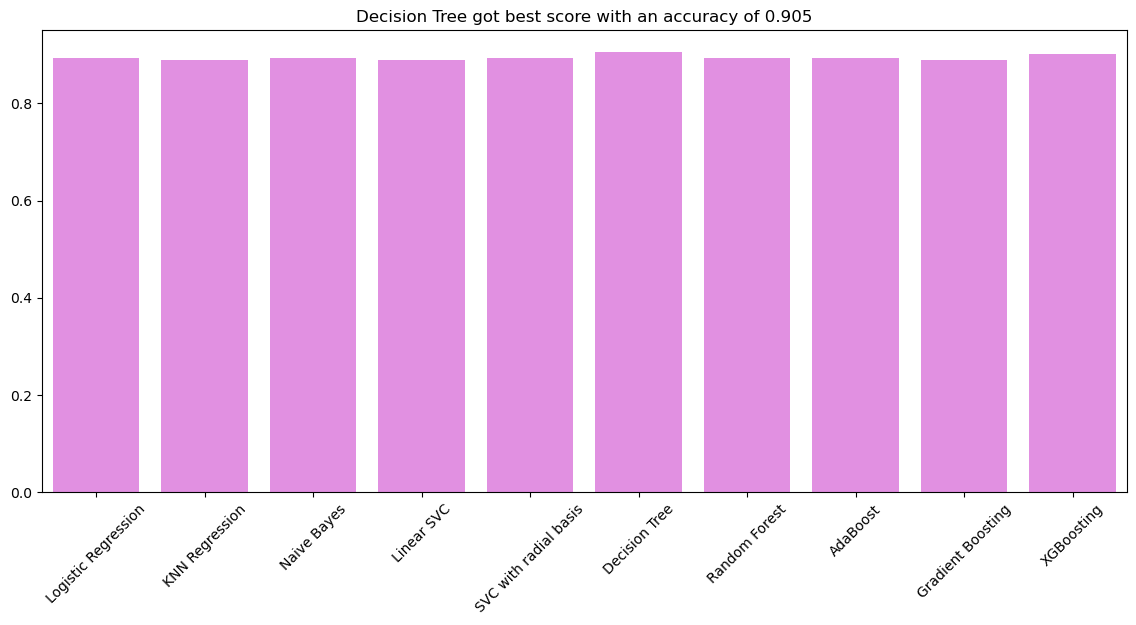

In [62]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(scores_df["model_name"]),
            y=list(scores_df["F1"]), color="violet")
plt.title(f"{best_score['model_name'][0]} got best score with an accuracy of {best_score['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.show()

### Compare model performance after cross validation

#### Calculate scores

In [63]:
scores_cv = {}
scores_cv['log_reg'] = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['knn'] = cross_val_score(pipeline_knn, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['nb'] = cross_val_score(pipeline_nb, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm'] = cross_val_score(pipeline_svm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['svm_rbf'] = cross_val_score(pipeline_svm_rbf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['dtree'] = cross_val_score(pipeline_dtree, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['rf'] = cross_val_score(pipeline_rf, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['ada_boost'] = cross_val_score(pipeline_ada_boost, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['gbm'] = cross_val_score(pipeline_gbm, X_train, y_train, cv=5, scoring='f1_weighted')
scores_cv['xgb'] = cross_val_score(pipeline_xgb, X_train, y_train_le, cv=5, scoring='f1_weighted')

c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
c:\Users\Catalina\.conda\envs\MLG\lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solv

In [64]:
scores_cv_df = pd.DataFrame({
    "model_name" : scores_cv.keys(),
    'F1': [round(np.mean(scores), 3) for scores in scores_cv.values()]
})

scores_cv_df

,model_name,F1
0,log_reg,0.888
1,knn,0.887
2,nb,0.888
3,svm,0.895
4,svm_rbf,0.888
5,dtree,0.894
6,rf,0.888
7,ada_boost,0.888
8,gbm,0.895
9,xgb,0.888


#### Choose best score

In [65]:
best_score_cv = scores_cv_df[scores_cv_df["F1"] == scores_cv_df["F1"].max()].reset_index(drop=True)
best_score_cv

,model_name,F1
0,svm,0.895
1,gbm,0.895


In [66]:
print(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")

svm got best score with an accuracy of 0.895


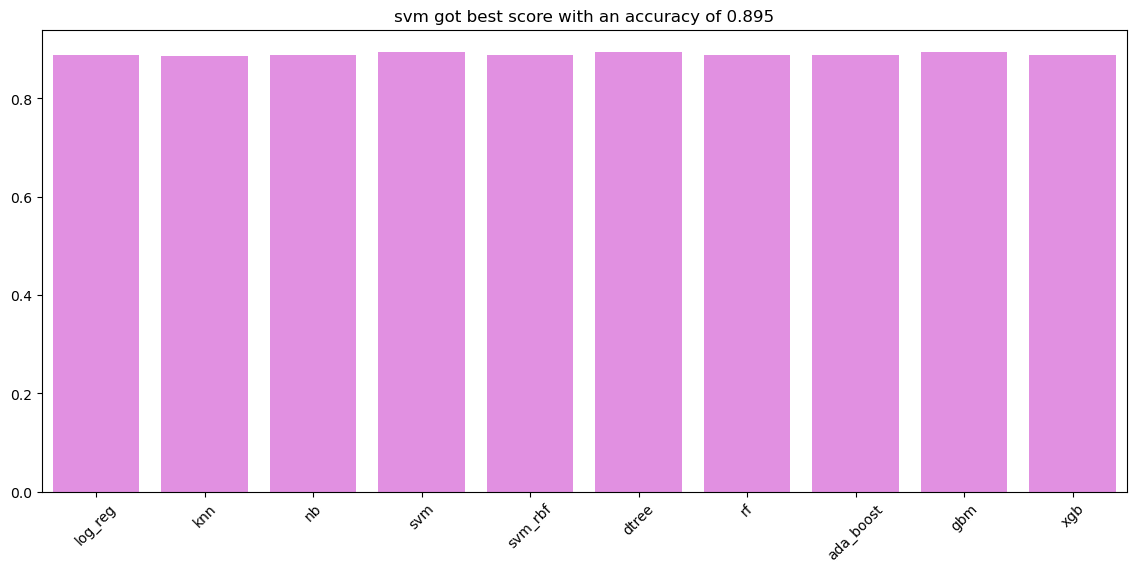

In [67]:
plt.figure(figsize=(14, 6))
sns.barplot(x=list(scores_cv_df["model_name"]),
            y=list(scores_cv_df["F1"]), color="violet")
plt.title(f"{best_score_cv['model_name'][0]} got best score with an accuracy of {best_score_cv['F1'][0]:.3f}")
plt.xticks(rotation=45)
plt.show()

# Hyperparameter tuning

 Approach
 1. Use Randomized Search to narrow down wide range of hyperparameters.
 2. Then use grid search to optimize in the close range of the result from RandomizedSearch

## Select best model (for hyperparameter tuning)

In [68]:
def assign_best_model(model_name):    

    model={}

    if model_name == "log_reg":
        best_model = LogisticRegression(random_state=42, solver='liblinear')
    elif model_name == "knn":
        best_model = KNeighborsClassifier()
    elif model_name == "nb":
        best_model = BernoulliNB()
    elif model_name == "svm":
        best_model = LinearSVC()
    elif model_name == "svm_rbf":
        best_model = SVC(kernel="rbf", gamma="scale")
    elif model_name == "dtree":
        best_model = DecisionTreeClassifier(random_state=42)
    elif model_name == "rf":
        best_model = RandomForestClassifier(random_state=42)
    elif model_name == "ada_boost":
        best_model = AdaBoostClassifier(random_state=42)
    elif model_name == "gbm":
        best_model = GradientBoostingClassifier(random_state=42)
    elif model_name == "xgb":
        best_model = XGBClassifier(random_state=42)    
    
    model["model"] = best_model

    need_scaling = ["log_reg", "knn","nb", "svm", "svm_rbf"]
    if model_name in need_scaling:
        model["needs_scaling"] = True
    else:
        model["needs_scaling"] = False
    
    return model

In [69]:
best_model = assign_best_model(best_score_cv['model_name'][0])
print(best_model)
best_model["model"]

{'model': LinearSVC(), 'needs_scaling': True}


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,None


## Randomized Search

### Preprocessing and defining pipeline

In [70]:
def preprocess_model(model):
    if model["needs_scaling"] == True:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        num_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", num_transformer, numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
    else:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", "passthrough", numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
        
    return preprocessor

In [71]:
best_model_preprocessor = preprocess_model(best_model)
best_model_preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [72]:
model_pipeline = Pipeline(steps=[
                              ("pre_process", best_model_preprocessor),
                              ("model", best_model["model"])
                              ])
model_pipeline

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Running the randomized search

In [73]:
# this works for different models
# ⚠️ "model" is the name from the pipeline!
rand_params = [
    {
        "model":[LogisticRegression(max_iter=1000, solver='liblinear')],
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__penalty": ["l1", "l2"]
    },
    {   "model": [KNeighborsClassifier()], 
        "model__n_neighbors": [1, 3, 5, 7, 9],
        "model__weights": ["uniform", "distance"]
    },
    {   "model": [BernoulliNB()],
        "model__alpha": [0.1, 0.5, 1.0]
    },
    {   "model": [LinearSVC(max_iter=2000)], 
        "model__C": [0.01, 0.1, 1, 5, 10, 100],
        "model__penalty": ["l2"],
        "model__loss": ["squared_hinge"]
    },
    {
        "model": [SVC()],
        "model__C": [0.01, 0.1, 1, 5, 10, 100],
        "model__kernel": ["rbf", "poly"],
        "model__gamma": ["scale"],
        "model__decision_function_shape": ["ovo", "ovr"]
    },
    {
        "model":[DecisionTreeClassifier()],
        "model__max_depth": [None, 3, 5, 7, 10],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    {
        "model": [RandomForestClassifier()],
        "model__n_estimators": list(range(50, 950, 100)),
        "model__max_depth": [None, 1, 2, 5, 7, 10, 15, 25, 40],
        "model__min_samples_split": [2, 5, 10],
        "model__min_samples_leaf": [1, 2, 4]
    },
    {
        "model":[AdaBoostClassifier(random_state=42)],
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.01, 0.1, 0.5, 1.0]
    },
    {
        "model":[GradientBoostingClassifier(random_state=42)],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__subsample': [0.6, 0.8, 1.0]
    },
    {
        "model":[XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
        "model__n_estimators": [50, 100, 200],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.01, 0.1, 0.2],
        "model__subsample": [0.6, 0.8, 1.0],
        "model__colsample_bytree": [0.6, 0.8, 1.0]
    }
]


- some searches need some hyperparametrization of the scoring, when the outcome is more than 2 options

In [74]:
# Define scoring for multiclass
scoring = {
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score)
}

In [75]:
rand_cv = RandomizedSearchCV(
    estimator=model_pipeline,
    param_distributions=rand_params,
    cv=5,
    n_iter=25,
    scoring=scoring,   
    refit='f1_weighted',
    verbose=1, 
    n_jobs=-1,
    error_score='raise'
)

- In case best model needs label encoding before fitting

In [76]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)

In [77]:
model_name = best_model["model"].__class__.__name__
model_name

'LinearSVC'

In [81]:
# i don't which models wiill give the follwoing error
# ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ['Bronze' 'Gold' 'Silver' 'no medal']
try:
    rand_cv.fit(X_train, y_train)
except ValueError:
    rand_cv.fit(X_train, y_train_le)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [ ]:
print(f"Best F1-score: {rand_cv.best_score_:.3f}\n")
print("-------------------------------------------------------------")
print(f"Best parameter set: {rand_cv.best_params_}\n")
print("-------------------------------------------------------------")

try:
    print(f"Scores:\n {classification_report(y_train, rand_cv.predict(X_train))}")
except ValueError:
    print(f"Scores:\n {classification_report(y_train_le, rand_cv.predict(X_train))}")

Best F1-score: 0.891

-------------------------------------------------------------
Best parameter set: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.01, 'model': GradientBoostingClassifier(random_state=42)}

-------------------------------------------------------------
Scores:
               precision    recall  f1-score   support

           0       1.00      0.16      0.27        19
           1       1.00      0.16      0.27        19
           2       1.00      0.19      0.32        16
           3       0.94      1.00      0.97       662

    accuracy                           0.94       716
   macro avg       0.98      0.38      0.46       716
weighted avg       0.94      0.94      0.92       716



## Grid Search

### Getting best model with best params after randomized search

In [85]:
params = rand_cv.best_params_ 
print(type(params))
params

<class 'dict'>


{'model__subsample': 1.0,
 'model__n_estimators': 200,
 'model__max_depth': 3,
 'model__learning_rate': 0.01,
 'model': GradientBoostingClassifier(random_state=42)}

In [86]:
grid_model = params["model"]
grid_model

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [87]:
# grid_params = [
#     {
#         'model__n_estimators': list(range(250, 450, 20)),
#         "model__min_samples_split": [2, 5, 10],
#         "model__min_samples_leaf": [1, 2, 4],
#         'model__max_depth': list(range(1,10,1)),
#     }
# ]

### Preprocessing and defining pipeline

In [88]:
def needs_scaling(model_name):    
    need_scaling = [LogisticRegression(), KNeighborsClassifier(),BernoulliNB(), LinearSVC(), SVC()]
    if model_name in need_scaling:
        return True
    else:
        return False

In [89]:
def preprocess_grid_model(model):
    if needs_scaling(model) == True:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        num_transformer = Pipeline(steps=[("scaler", StandardScaler().set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", num_transformer, numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
    else:
        categ_transformer = Pipeline(steps=[("onehot", OneHotEncoder(sparse_output=False, handle_unknown="ignore").set_output(transform="pandas"))])
        preprocessor = ColumnTransformer(transformers=[("num", "passthrough", numeric_features),
                                                       ("cat", categ_transformer, categorical_features)
                                                       ]).set_output(transform="pandas")
        
    return preprocessor

In [90]:
grid_model_preprocessor = preprocess_grid_model(grid_model)

In [91]:
grid_model_pipeline = Pipeline(steps=[
                              ("pre_process", best_model_preprocessor),
                              ("model", best_model["model"])
                              ])
grid_model_pipeline

,steps,"[('pre_process', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Stacking classifier